# Seuratの使い方

## はじめに

このノートブックではシングルセルオミックスデータ解析で広く用いられているSeuratの使い方を紹介します。

基本的な操作を紹介している以下のページを簡略化させたものとなっています。
https://satijalab.org/seurat/articles/pbmc3k_tutorial

Seuratの公式ページでは、2025/1/7現在で65ものドキュメントが用意されているため、各自のデータ解析の目的に応じてチェックしてみてください。
https://satijalab.org/seurat/articles/

## パッケージのインストール（10分程度かかる）

R言語のパッケージレポジトリCRANからSeuratパッケージをインストールします。

In [1]:
if (!require("Seurat", quietly = TRUE)){
    install.packages("Seurat", repos="https://cloud.r-project.org")
}


次のパッケージを付け加えます: ‘SeuratObject’


以下のオブジェクトは ‘package:base’ からマスクされています:

    intersect, t




## パッケージのロード

Seuratパッケージをロードして、パッケージ内で実装された関数が利用できるようにします。

In [2]:
library(Seurat)

## PBMCデータセットのダウンロード

ここでは、デモ用に10X Genomics社が提供しているヒト末梢血単核細胞（Peripheral Blood Mononuclear Cells; PBMC）2,700細胞のデータに対して、Cell Rangerを実行した結果のファイルセットを手元にダウンロードしておきます。

分化した血球細胞が含まれるため、クラスタ構造が現れやすく、シングルセルデータ解析においては、デモデータとして多用されます。

In [3]:
download.file("https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz", destfile="pbmc3k_filtered_gene_bc_matrices.tar.gz")

In [4]:
untar("pbmc3k_filtered_gene_bc_matrices.tar.gz")

## PBMCデータを読み込み

SeuratのRead10X関数を使うことで、Cell Rangerの結果ファイルセットをRに読み込むことができます。

In [5]:
pbmc.data <- Read10X(data.dir = "filtered_gene_bc_matrices/hg19/")
str(pbmc.data)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:2286884] 70 166 178 326 363 410 412 492 494 495 ...
  ..@ p       : int [1:2701] 0 781 2133 3264 4224 4746 5528 6311 7101 7634 ...
  ..@ Dim     : int [1:2] 32738 2700
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:32738] "MIR1302-10" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  .. ..$ : chr [1:2700] "AAACATACAACCAC-1" "AAACATTGAGCTAC-1" "AAACATTGATCAGC-1" "AAACCGTGCTTCCG-1" ...
  ..@ x       : num [1:2286884] 1 1 2 1 1 1 1 41 1 1 ...
  ..@ factors : list()


さらに、CreateSeuratObject関数を実行することで、Seuratオブジェクトに変換でき、Seuratパッケージの各種関数が適用できるようになります。

In [6]:
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

なお、min.cells=3は最低3細胞で発現されている遺伝子を残す、min.features=200は、最低200遺伝子を発現している細胞を残すというオプションであり、ここで簡単なフィルタリングも行えます。

## Quality Control (QC)

以下では、細胞に対するフィルタリングをさらに行っており、RNAの発現量が200より大きく、2,500より小さく、かつミトコンドリア由来の発現量の割合が5%より小さい細胞だけを残しています。

In [7]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## 正規化

細胞ごとに全遺伝子の発現量を総発現量で割り、さらに10,000をかけてから対数を取っています。

In [8]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



## Highly Variable Genes（HVGs）検出

細胞間で変動が大きい遺伝子を2,000遺伝子検出しています。

In [9]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

Finding variable features for layer counts



## 主成分分析（Principal Component Analysis; PCA）

2,000のHVGsを元にPCAで細胞を低次元に射影します。

In [10]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

Centering and scaling data matrix

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A,

PC1 vs PC2で散布図を描くと、クラスタ構造が確認されます。

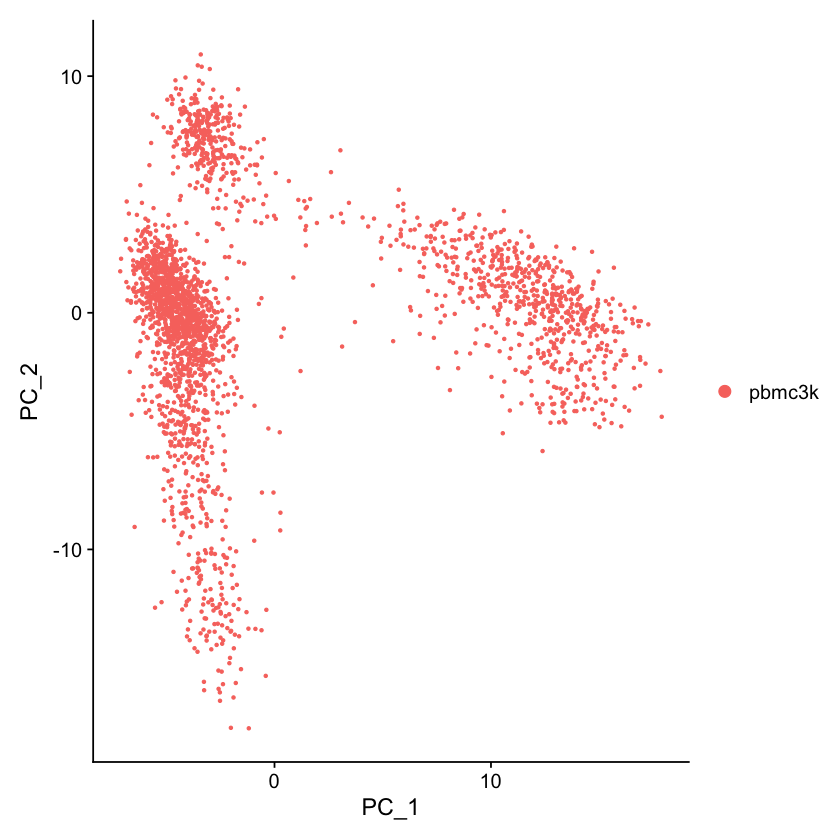

In [11]:
DimPlot(pbmc, reduction = "pca")

## クラスタリング

さらに、Louvainクラスタリングを利用して、クラスタごとに色分けを行います。

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95927

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8728
Number of communities: 9
Elapsed time: 0 seconds


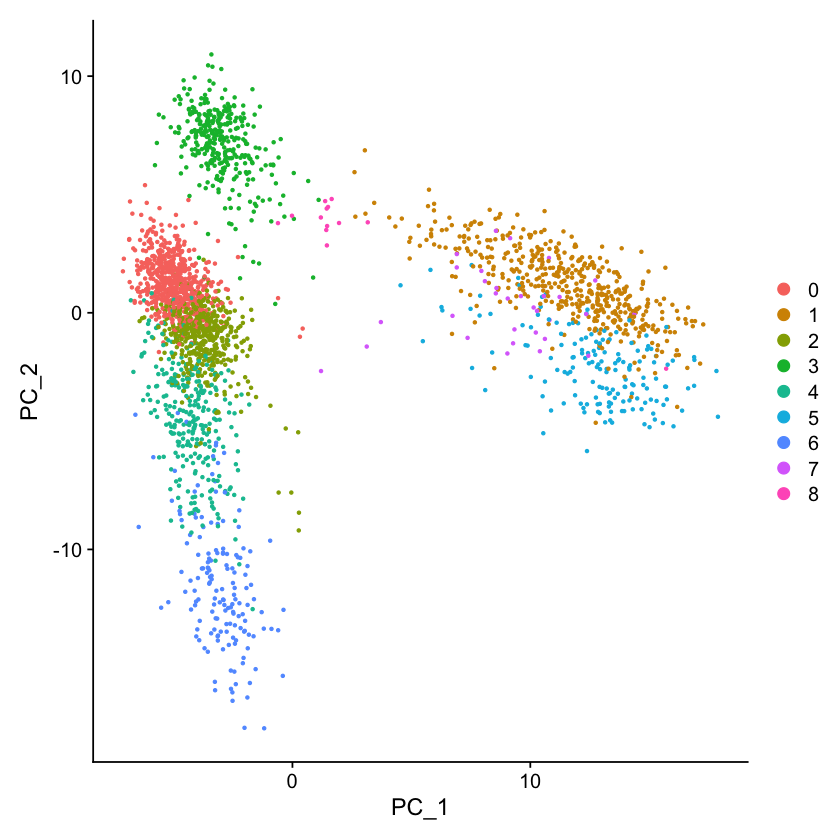

In [12]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)
DimPlot(pbmc, reduction = "pca")

## UMAP

より非線形な次元圧縮手法としてUMAPがあり、PC1からPC10までを利用して、細胞を2次元に射影します。

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:56:31 UMAP embedding parameters a = 0.9922 b = 1.112

17:56:31 Read 2638 rows and found 10 numeric columns

17:56:31 Using Annoy for neighbor search, n_neighbors = 30

17:56:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:56:31 Writing NN index file to temp file /var/folders/7y/6rcx20m57tj3qdnqsl9z5k480000gn/T//RtmpNt7Q13/file1770b4ca7ce10

17:56:31 Searching Annoy index using 1 thread, search_k = 3000

17:56:32 Annoy recall = 100%

17:56:32 Commencing smooth kNN distance calibra

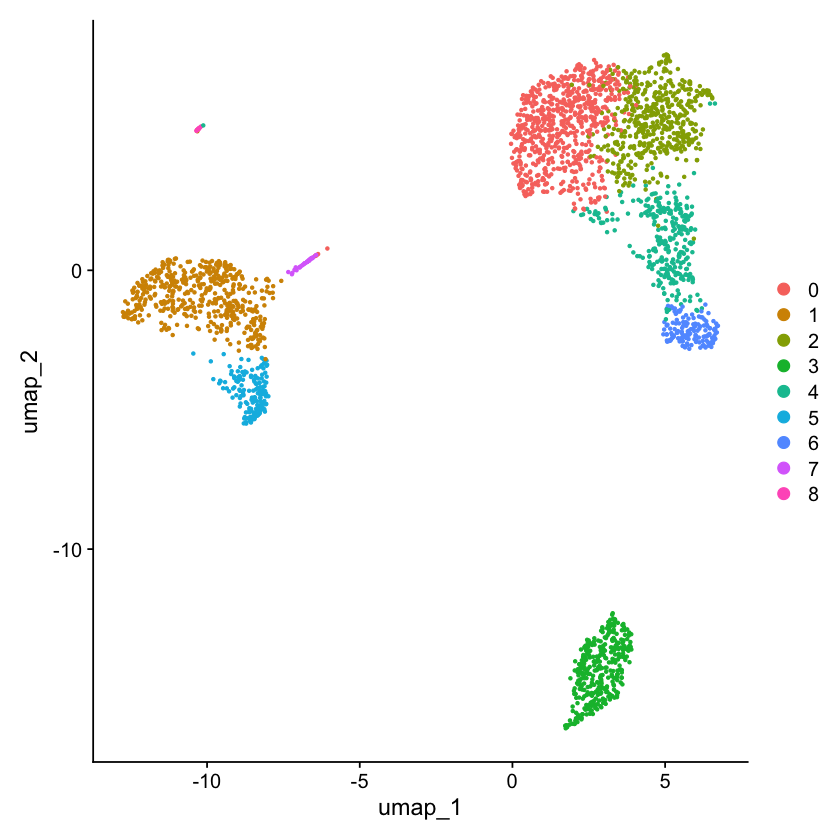

In [13]:
pbmc <- RunUMAP(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "umap")

## 終わりに

Seuratの公式ドキュメントでは、
https://satijalab.org/seurat/articles/pbmc3k_tutorial
さらに、このクラスタごとに変動する遺伝子をFindMarkers関数で検出し、RenameIdents関数を利用して、クラスタ番号を細胞型名に変換し、以降の解析で利用しています。

## Session Information

In [14]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: aarch64-apple-darwin20.0.0
Running under: macOS Sonoma 14.6.1

Matrix products: default
BLAS/LAPACK: /Users/koki/anaconda3/lib/libopenblas.0.dylib;  LAPACK version 3.12.0

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

time zone: Asia/Tokyo
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Seurat_5.1.0       SeuratObject_5.0.2 sp_2.1-4          

loaded via a namespace (and not attached):
  [1] deldir_2.0-4           pbapply_1.7-2          gridExtra_2.3         
  [4] rlang_1.1.4            magrittr_2.0.3         RcppAnnoy_0.0.22      
  [7] spatstat.geom_3.3-4    matrixStats_1.4.1      ggridges_0.5.6        
 [10] compiler_4.4.1         png_0.1-8              vctrs_0.6.5           
 [13] reshape2_1.4.4         stringr_1.5.1          pkgconfig_2.0.3       
 [16] crayon_1.5.3           fastmap_1.2.0          label